"A (somewhat pedestrian) example of using TensorFlow for simulating the behavior of a partial differential equation. We'll simulate the surface of square pond as a few raindrops land on it."

# Import

In [23]:
#Import libraries for simulation
import tensorflow as tf
import numpy as np

#Imports for visualization
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display

from skimage.draw import circle

In [24]:
sess = tf.InteractiveSession()

/home/andy/.conda/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


# Utility functions

In [2]:
# likely also fine to use matplotlib's imshow?

def DisplayArray(a, fmt='jpeg', rng=[0,1]):
  """Display an array as a picture."""
  a = (a - rng[0])/float(rng[1] - rng[0])*255
  a = np.uint8(np.clip(a, 0, 255))
  f = BytesIO()
  PIL.Image.fromarray(a).save(f, fmt)
  clear_output(wait = True)
  display(Image(data=f.getvalue()))

In [4]:
def make_kernel(a):
  """Transform a 2D array into a convolution kernel"""
  a = np.asarray(a)
  a = a.reshape(list(a.shape) + [1,1])
  return tf.constant(a, dtype=1)

def simple_conv(x, k):
  """A simplified 2D convolution operation"""
  x = tf.expand_dims(tf.expand_dims(x, 0), -1)
  y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
  return y[0, :, :, 0]

def laplace(x):
  """Compute the 2D laplacian of an array"""
  laplace_k = make_kernel([[0.5, 1.0, 0.5],
                           [1.0, -6., 1.0],
                           [0.5, 1.0, 0.5]])
  return simple_conv(x, laplace_k)

# Simulate

## Pond

In [5]:
N = 500

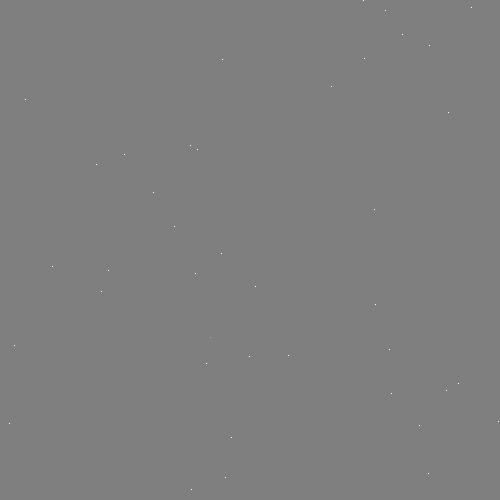

In [6]:
# Initial Conditions -- some rain drops hit a pond

# Set everything to zero
u_init = np.zeros([N, N], dtype=np.float32)
ut_init = np.zeros([N, N], dtype=np.float32)

# Some rain drops hit a pond at random points
for n in range(40):
  a,b = np.random.randint(0, N, 2)
  u_init[a,b] = np.random.uniform()

DisplayArray(u_init, rng=[-0.1, 0.1])

In [7]:
# Parameters:
# eps -- time resolution
# damping -- wave damping
eps = tf.placeholder(tf.float32, shape=())
damping = tf.placeholder(tf.float32, shape=())

# Create variables for simulation state
U  = tf.Variable(u_init)
Ut = tf.Variable(ut_init)

# Discretized PDE update rules
U_ = U + eps * Ut
Ut_ = Ut + eps * (laplace(U) - damping * Ut)

# Operation to update the state
step = tf.group(U.assign(U_), Ut.assign(Ut_))

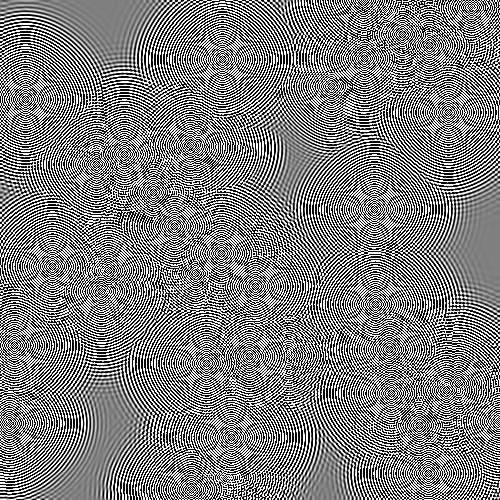

In [13]:
# Initialize state to initial conditions
tf.global_variables_initializer().run()

# Run 1000 steps of PDE
for i in range(3000):
    # Step simulation
    step.run({eps: 0.03, damping: 0.04})
    DisplayArray(U.eval(), rng=[-0.1, 0.1])

## Gray-Scott

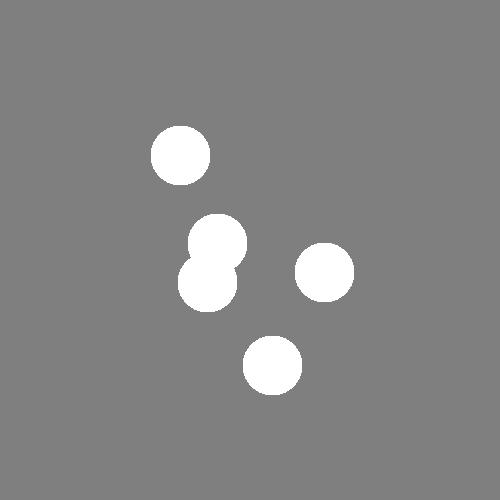

In [41]:
N = 500

# Initial Conditions -- some rain drops hit a pond

# Set everything to zero
u_init = np.ones([N, N], dtype=np.float32)
v_init = np.zeros([N, N], dtype=np.float32)

# Some rain drops hit a pond at random points
for n in range(5):
    a,b = np.random.randint(N/4, 3*N/4, 2)
    rr, cc = circle(a, b, 30, shape=(N,N))
    v_init[rr, cc] = 1

DisplayArray(v_init, rng=[-0.1, 0.1])

In [42]:
# Parameters:
# eps -- time resolution
# damping -- wave damping
dt = tf.placeholder(tf.float32, shape=())
a = tf.placeholder(tf.float32, shape=())
b = tf.placeholder(tf.float32, shape=())
k = tf.placeholder(tf.float32, shape=())
f = tf.placeholder(tf.float32, shape=())

# Create variables for simulation state
U  = tf.Variable(u_init)
V  = tf.Variable(v_init)

# Discretized PDE update rules
U_ = U + dt*(a*laplace(U) - U*V*V + f*(1-U))
V_ = V + dt*(b*laplace(V) + U*V*V - (k+f)*V)

# Operation to update the state
step = tf.group(U.assign(U_), V.assign(V_))

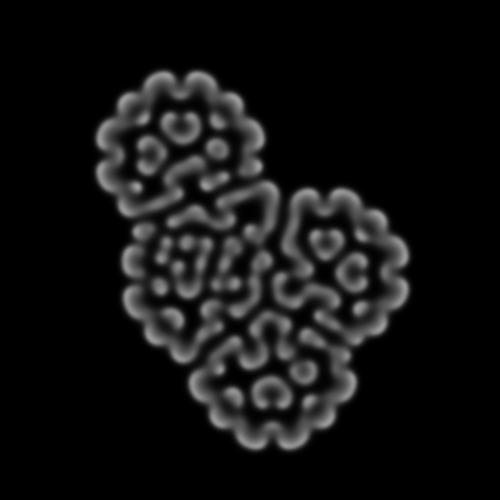

In [43]:
# Initialize state to initial conditions
tf.global_variables_initializer().run()

# Run 1000 steps of PDE
for i in range(5000):
    # Step simulation
    step.run({dt: 0.1, a: 1, b: 0.2, k: 0.059, f: 0.034})
    DisplayArray(V.eval(), rng=[0, 1])

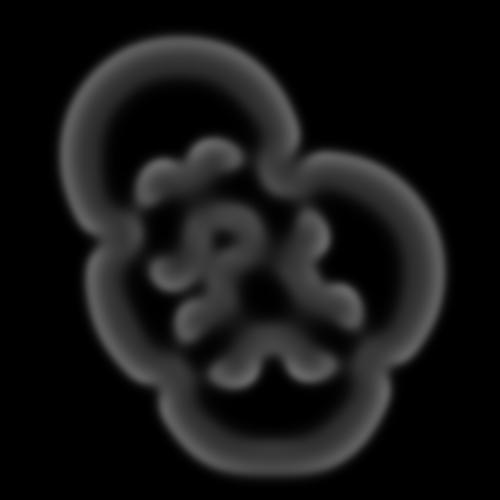

In [45]:
# Initialize state to initial conditions
tf.global_variables_initializer().run()

# Run 1000 steps of PDE
for i in range(5000):
    # Step simulation
    step.run({dt: 0.1, a: 1, b: 0.5, k: 0.053, f: 0.026})
    DisplayArray(V.eval(), rng=[0, 1])

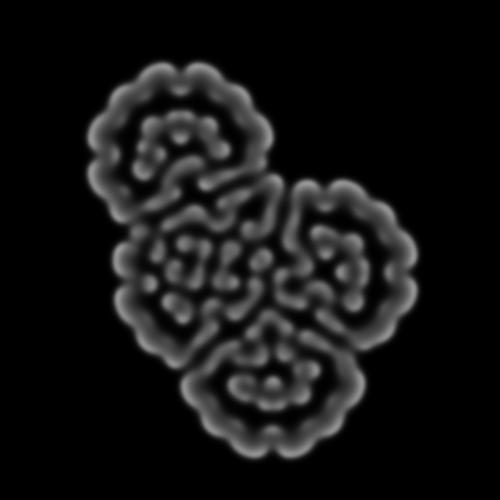

In [46]:
# Initialize state to initial conditions
tf.global_variables_initializer().run()

# Run 1000 steps of PDE
for i in range(5000):
    # Step simulation
    step.run({dt: 0.1, a: 1, b: 0.2, k: 0.053, f: 0.026})
    DisplayArray(V.eval(), rng=[0, 1])